In [2]:
import numpy as np
import os
import re
import gzip
import struct
import random
import time
import signal

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'gray'

from IPython.display import clear_output, display

from netlib import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
text = ""
ddir = "data/books/witcher_rus/"
for fn in sorted(os.listdir(ddir)):
    if fn.endswith(".gz"):
        with gzip.open(ddir + fn, "rb") as f:
            text += f.read().decode("utf-8").replace("\r", "")
charset = sorted(set(text))
print(charset)
print("%s chars, %s unique" % (len(text), len(charset)))
chidx = {ch: i for i, ch in enumerate(charset)}

raw_data = [chidx[ch] for ch in text]
data = np.array(raw_data, dtype=np.uint8)
dvec = np.eye(len(charset), dtype=np.float64)

['\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']
5088376 chars, 140 unique


In [4]:
signal_done = False

def signal_handler(signal, frame):
    global signal_done
    signal_done = True

def stop_on_signal():
    global signal_done
    signal_done = False
    signal.signal(signal.SIGINT, signal_handler)

## Char RNN

In [5]:
batch_size = 200

blen = len(data)//batch_size
print("%s chars in sequence" % blen)
bseqdata = data[:blen*batch_size].reshape(batch_size, blen).transpose()
#print(''.join([charset[k] for k in bseqdata.transpose()[-1]]))

25441 chars in sequence


In [6]:
class RNNSolver(Solver):
    def __init__(self, net, optims, **params):
        self.params = params
        self.name = params["name"]
        self.net = net
        
        if isinstance(optims, Optim):
            optims = [optims]
        self.optims = optims

        self.loss_history = []
        
    def learn(self, inseq, outseq, gprel=1):
        if inseq.shape[0] != outseq.shape[0]:
            mlen = min((inseq.shape[0], outseq.shape[0]))
            inseq = inseq[0:mlen]
            outseq = outseq[0:mlen]
        seqlen = inseq.shape[0]
        
        loss = 0.0
        cache = []

        guided = int(gprel*seqlen)
        
        h = self.net.newstate(inseq.shape[1])
        if isinstance(h, np.ndarray):
            h = (h,)
        for i, (x, r) in enumerate(zip(inseq, outseq)):
            if i <= guided:
                x = np.stack((x[:,0], np.zeros(x.shape[0]))).transpose()
            else:
                x = np.stack((y[:,0], np.ones(y.shape[0]))).transpose()
            ovs, m = self.net.forward((x, *h))
            y, h = ovs[0], ovs[1:]
            cache.append((m, y, r))
            loss += rms_loss(y, r)
        loss /= len(cache)

        grad = self.net.newgrad()
        dh = self.net.newstate(inseq.shape[1])
        if isinstance(dh, np.ndarray):
            dh = (dh,)
        for m, y, r in reversed(cache):
            ovs = self.net.backward(grad, m, (rms_deriv(y, r), *dh))
            dh = ovs[1:]

        modgrad(grad, norm=1, clip=5)
        for optim in self.optims:
            optim.learn(self.net, grad)

        self.loss_history.append(loss)
            
    def sample(self, seed, seqlen):
        h = self.net.newstate(1)
        if isinstance(h, np.ndarray):
            h = (h,)
        seq = []
        x = seed
        seq += seed
        for i in range(seqlen):
            ovs, _ = self.net.forward((x, *h))
            y, h = ovs[0], ovs[1:]
            seq.append(y)
            x = y
        return seq


def plot_solvers(plt, sols, red=10, win=100):
    if isinstance(sols, Solver):
        sols = [sols]
        
    plt.subplot(2, 1, 1)
    for sol in sols:
        lh = np.array(sol.loss_history)
        lh.resize(lh.shape[0]//red, red)
        plt.plot(np.mean(lh, axis=-1), label=sol.name)
    plt.legend()

    plt.subplot(2, 1, 2)
    for sol in sols:
        plt.plot(
            sol.loss_history[-win:], 
            label="%s loss: %.4f" % (sol.name, sol.loss_history[-1])
        )
    plt.legend()
    
plt.show()

In [7]:
def run_solvers(solvers, seqlen, pos=0, plot=True):
    stop_on_signal()
    while not signal_done:
        for i, sol in enumerate(solvers):
            if len(sol.loss_history) == 0 or not np.isnan(sol.loss_history[-1]):
                sol.learn(dvec[bseqdata[pos:pos+seqlen]], bseqdata[pos+1:pos+seqlen+1])
        if plot:
            clear_output(wait=True)
            plot_solvers(plt, solvers)
        
        pos += seqlen
        if pos >= bseqdata.shape[0] - 1:
            pos = 0
    return pos

In [11]:
seqlen = 100
hidden_size = 20

solvers = [
    RNNSolver(
        RNN([len(charset), hidden_size, len(charset)]),
        Adam(2e-2), name=("Vanilla RNN")
    ),
    RNNSolver(
        LSTM([len(charset), hidden_size, len(charset)]),
        Adam(2e-2), name=("LSTM")
    ),
]
pos = 0

In [12]:
pos = run_solvers(solvers, seqlen, pos)

ValueError: shape-mismatch for sum

In [ ]:
for sol in solvers:
    print("[%s]" % sol.name)
    print(sol.sample(data[pos], 1000))

## Word2Vec

In [5]:
from collections import Counter

wtxt = re.sub("[\n !\"'\\(\\)\\*,\\-\\.0123456789:;?]+", " ", text.lower()).split()
wcnt = Counter(wtxt)
occ = 5
wcnt_top = {w: c for w, c in wcnt.items() if c > occ}
print("\n".join(["%s:\t%s" % (c, w) for w, c in wcnt.most_common(40)]))
print("%s words with more than %s occurences" % (len(wcnt_top), occ))

24656:	и
17760:	не
16372:	в
12700:	на
10526:	что
8093:	я
7083:	с
6611:	а
5500:	как
5388:	он
5070:	ты
4680:	то
4667:	из
4467:	это
4074:	но
3979:	она
3811:	за
3458:	к
3389:	у
3160:	по
3122:	его
3047:	геральт
2730:	от
2726:	так
2571:	о
2563:	все
2422:	ее
2367:	же
2273:	было
2210:	меня
2116:	цири
1961:	бы
1951:	мне
1943:	ведьмак
1854:	мы
1852:	тебя
1845:	еще
1803:	они
1767:	уже
1756:	если
14544 words with more than 5 occurences


In [6]:
wocc = sorted(wcnt_top.items(), key=lambda x: -x[1])
words = [w for w, c in wocc]
freqs = np.array([c for w, c in wocc], dtype=np.float64)
freqs /= np.sum(freqs)
print(freqs)

wmap = {w: i for i, w in enumerate(words)}
wtxt_top = [w for w in wtxt if w in wmap.keys()]
print(wtxt_top[100:200])
nums_top = np.array([wmap[w] for w in wtxt if w in wmap.keys()])

[3.94785931e-02 2.84368840e-02 2.62144519e-02 ... 9.60705542e-06
 9.60705542e-06 9.60705542e-06]
['и', 'как', 'бы', 'нетерпеливо', 'наклонилась', 'коснулась', 'его', 'века', 'щеки', 'губ', 'он', 'улыбнулся', 'медленно', 'осторожно', 'нежно', 'взял', 'ее', 'руки', 'в', 'свои', 'она', 'выпрямилась', 'от', 'его', 'пальцев', 'и', 'от', 'этого', 'света', 'в', 'зари', 'он', 'пошевелился', 'но', 'она', 'решительным', 'нажимом', 'обеих', 'рук', 'остановила', 'его', 'и', 'но', 'движениями', 'бедер', 'ответа', 'он', 'ответил', 'она', 'уже', 'не', 'избегала', 'его', 'рук', 'откинула', 'голову', 'волосами', 'ее', 'кожа', 'была', 'холодной', 'и', 'поразительно', 'гладкой', 'глаза', 'которые', 'он', 'увидел', 'когда', 'она', 'свое', 'лицо', 'к', 'его', 'лицу', 'были', 'огромными', 'и', 'темными', 'как', 'глаза', 'русалки', 'покачиваясь', 'он', 'в', 'море', 'а', 'оно', 'и', 'зашумело', 'потеряв', 'покой', 'ведьмак', 'потом', 'говорили', 'что', 'человек', 'этот', 'пришел', 'с']


In [7]:
class W2VNet(Net):
    def __init__(self, sizes, ws=None):
        self.sizes = sizes
        words_count, vec_size = sizes
        layers = [SparseAffine(words_count, vec_size, mag=ws), AffineSparse(vec_size, words_count, mag=ws)]
        links = [
            ((-1, 0), (0, 0)), # xv
            ((-1, 1), (0, 1)), # xi
            (0, (1, 0)), # h
            ((-1, 2), (1, 1)), # yi
            (1, -1), # yv
        ]
        super().__init__(layers, links)

In [8]:
class History:
    def __init__(self):
        self.t = []
        self.acc = []
        self.loss = []
        
    def append(self, t, acc, loss):
        self.t.append(t)
        self.acc.append(acc)
        self.loss.append(loss)

In [9]:
def plot(history):
    plt.subplot(2, 1, 1)
    plt.plot(history.t, history.loss)
    plt.title("Loss: %s" % history.loss[-1])
    
    plt.subplot(2, 1, 2)
    plt.plot(history.t, history.acc)
    #plt.yscale("log")
    plt.title("Accuracy: %s" % history.acc[-1])
    
    plt.show()

In [10]:
word_dist = 2
out_count = 5

pairs = None
for i in range(-word_dist, word_dist+1):
    if i == 0:
        continue
    if i < 0:
        ps = np.stack((nums_top[-i:], nums_top[:i]))
    else:
        ps = np.stack((nums_top[:-i], nums_top[i:]))
    if pairs is None:
        pairs = ps
    else:
        np.append(pairs, ps, axis=-1)

pairs = pairs.reshape(-1, 2)
        
print(pairs)

[[  834   778]
 [ 4854  3884]
 [ 7698    15]
 ...
 [ 1407   141]
 [    1 14483]
 [   18    29]]


In [26]:
vec_size = 64
batch_size = 1000
weight_scale = 1e-2

solver = Solver(
    net=W2VNet((len(words), vec_size), weight_scale), 
    loss=Binary(), optims=[Adam(learn_rate=1e-2)],
)

In [27]:
pos = 0
epoch = 0
history = History()
smooth_loss = None
smooth_hits = None
k_smooth = 0.9

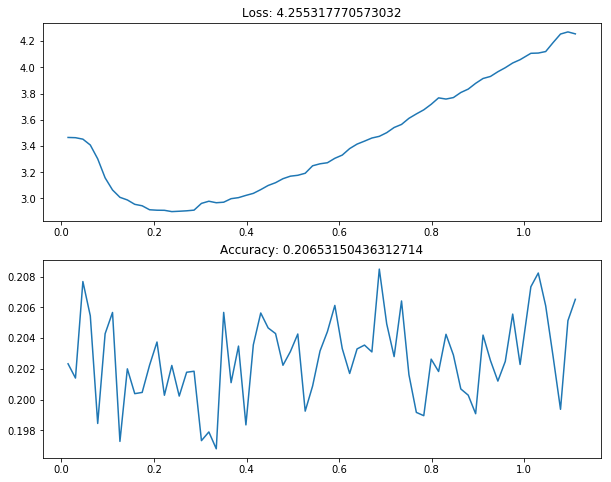

In [28]:
stop_on_signal()
while not signal_done:
    batch_pairs = pairs[pos:pos+batch_size]
    xi = batch_pairs[:,0].reshape(-1,1)
    xv = np.ones_like(xi, dtype=np.float32)
    yi = np.stack(
        [batch_pairs[:,1]] + [np.random.choice(freqs.shape[0], xi.shape[0], p=freqs) for _ in range(out_count-1)]
    ).reshape(xi.shape[0], -1)
    yr = np.zeros(xi.shape[0], dtype=np.int32).reshape(-1, 1)
    
    y, loss, _ = solver.learn((xv, xi, yi), yr)
    hits = np.sum(np.equal(np.argmax(y, axis=-1), 0))/y.shape[0]
    
    if smooth_loss is None:
        smooth_loss = loss
    smooth_loss = k_smooth*smooth_loss + (1-k_smooth)*loss
    if smooth_hits is None:
        smooth_hits = hits
    smooth_hits = k_smooth*smooth_hits + (1-k_smooth)*hits
    
    if (pos//batch_size + 1)% 10 == 0:
        history.append(
            epoch + pos/pairs.shape[0],
            smooth_hits,
            smooth_loss
        )

        clear_output(wait=True)
        plot(history)
    
    pos += batch_size
    if pos >= pairs.shape[0]:
        pos = 0
        epoch += 1
        hits = 0

In [27]:
word_vec = solver.net.nodes[0].W + solver.net.nodes[1].W
print(word_vec)

[[ 1.30992193  0.7486628   1.01174999 ...  1.6900951  -1.18645457
  -1.79528195]
 [ 1.68731242  0.70230722  0.62579114 ...  1.04383953 -1.28518824
  -1.39667214]
 [ 1.24185665  0.91072149  0.78264821 ...  1.70290727 -1.24957347
  -1.98131888]
 ...
 [ 0.05379511 -0.03683257  0.12224404 ...  0.067388   -0.0763676
  -0.02830217]
 [ 0.0579678   0.02949584  0.01079382 ...  0.11295779 -0.12742588
  -0.13277876]
 [ 0.15311482  0.14986543  0.10740822 ...  0.12219131 -0.10511877
  -0.15469265]]


In [30]:
def sort_nearest(word_vec, word):
    dist = np.sum((word_vec - word)**2, axis=-1)
    return np.argsort(dist)

In [31]:
print(np.array(words)[sort_nearest(word_vec, word_vec[wmap["идет"]])[:100]])

['идет' 'видишь' 'золтан' 'ясно' 'благодарю' 'эльф' 'обычно' 'моей' 'весь'
 'этим' 'ночь' 'короля' 'подумала' 'пошли' 'таких' 'сколько' 'мое'
 'вместо' 'ривии' 'возможно' 'кому' 'буду' 'лошадей' 'ха' 'твои' 'свои'
 'скорее' 'эльфов' 'казалось' 'поскольку' 'улыбнулся' 'глазах' 'твой'
 'землю' 'таким' 'которым' 'холодно' 'начал' 'таки' 'начала' 'жизнь'
 'видела' 'дийкстра' 'прервал' 'скажу' 'отсюда' 'крикнула' 'ко' 'эй'
 'двух' 'вероятно' 'смерть' 'нос' 'мечом' 'говорю' 'этих' 'трудом' 'знала'
 'ветер' 'слово' 'думал' 'геральту' 'давно' 'хотела' 'филиппа' 'нем'
 'меча' 'давай' 'наверняка' 'собой' 'сделал' 'чародей' 'увидел' 'похоже'
 'спиной' 'свой' 'стол' 'продолжал' 'чуть' 'цинтры' 'сделать' 'против'
 'рук' 'ради' 'говори' 'громко' 'дня' 'королева' 'стоит' 'колени' 'мои'
 'риенс' 'вроде' 'других' 'нельзя' 'едва' 'далеко' 'самое' 'видеть' 'ярре']
